# Usage of the Event Detector by Zheng et al.

# Load the required packages

In [11]:
# Import public packages
import sys
import os
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import glob
from datetime import datetime, timedelta
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_Zheng
import BLUED_loader as blued

# Activate Autoreload
%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [12]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
DATASET = "blued_events" #name of the dataset (used to load the file later with my Utility class)
CURRENT_COLUMN = "Current B" # Dataset has two phases: phase A and B. They can be treated independently. We load only Phase B.
NETWORK_FREQUENCY_BLUED = 60 # Base electrical network frequency of the region where the dataset was recorded
SAMPLES_PER_SECOND_BLUED = 2 # We compute two features (data points) per second.
SAMPLERATE_BLUED = 12000 # Sampling Rate the raw BLUED Dataset was recorded with 


# Compute the period size of the BLUED dataset: i.e. number of raw data points per period
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 

# Load and display the BLUED Test File

<IPython.core.display.Javascript object>


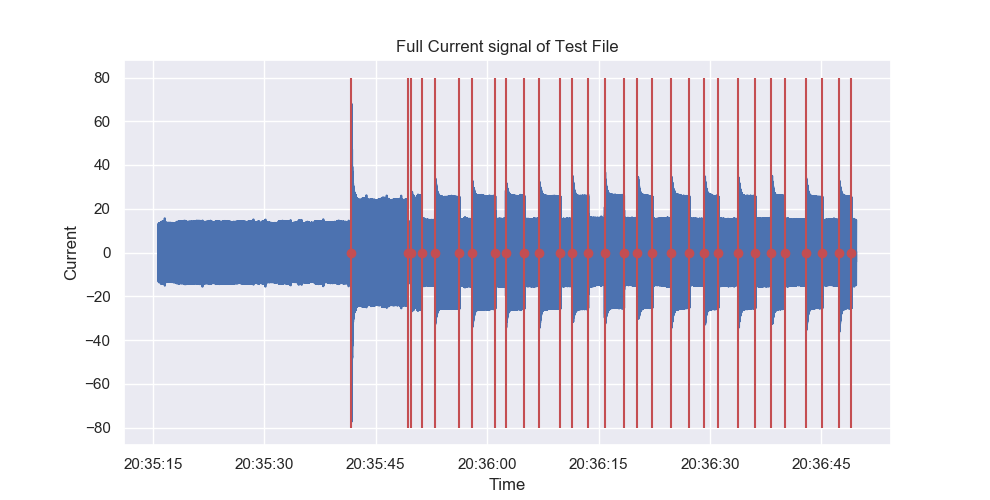

In [13]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data, file_info = blued.load_file(test_file)

lable_path:str = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.csv"))[0]
data_start = file_info['file_start']
data_end = file_info['file_end']

labels = blued.load_labels(lable_path, data_start, data_end)

current = data["Current"]
voltage = data["Voltage"]

# Plot the data from the test File
_, ax = plt.subplots(figsize=(9.9,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=labels.index, color='r',ymin=-80, ymax=80, zorder=101)
plt.show()

# Run the Event Detection on the Test Data

In [14]:
found_events=[]
show_plots = False

samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window

# Step 1: Initialize  the Event Detector with the Hypperparameter dictionary 
Zheng = EventDet_Zheng(network_frequency=NETWORK_FREQUENCY_BLUED, eps=0.1, min_pts=25, window_size=300, p_thre=25, t_thre=0.01)
Zheng.fit() # Call the fit() method to further initialize the algorithm (required by the sklearn API)

window_size_seconds = Zheng.window_size_sec
samples_raw_per_window_BLUED = window_size_seconds * SAMPLERATE_BLUED
window_start_timestamp = file_info["file_start"]

while samples_remaining >= samples_raw_per_window_BLUED: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + samples_raw_per_window_BLUED) # compute end index of the new window
    window_end_timestamp = window_start_timestamp + timedelta(seconds=window_size_seconds)

    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]
    
    print(">"+ f" ({window_start}-{window_stop})")

    # Step 2: Use the feature computation function of the algorithm to compute the input features
    active_power, current_rms = Zheng.compute_input_signal(voltage=voltage_window, current=current_window,period_length=BLUED_period)
    
    # Plot the computed features
    if show_plots:
        plt.title("Computed input features for this window")
        plt.scatter(active_power, current_rms)
        plt.show()
    
    # Step 3: Run the prediciton on the features
    events, non_postprocessed_events = Zheng.predict(active_power=active_power,
                                                              current_rms=current_rms,
                                                              start_timestamp=window_start_timestamp,
                                                              end_timestamp=window_end_timestamp,
                                                                return_non_postprocessed=True)
    
    if len(non_postprocessed_events) > 0: # if an event is returned (here without the postprocessing, see algorithm description)
        
        for event in non_postprocessed_events:
            
            print("Event Detected at " + str(event))
            found_events.append(str(event))
        
        print("+++++++++++++++++++++++++++++++++++")

        
    # We start at the end of the previous window
    window_start = int(window_stop)
    window_start_timestamp = window_end_timestamp
    
    # We need to update the data points that remain for streaming now.
    samples_remaining -= samples_raw_per_window_BLUED

> (0-60000)
> (60000-120000)
> (120000-180000)
Event Detected at 2011-10-23 20:35:29.290166
+++++++++++++++++++++++++++++++++++
> (180000-240000)
> (240000-300000)
> (300000-360000)
Event Detected at 2011-10-23 20:35:42.023499
+++++++++++++++++++++++++++++++++++
> (360000-420000)
Event Detected at 2011-10-23 20:35:49.973499
+++++++++++++++++++++++++++++++++++
> (420000-480000)
Event Detected at 2011-10-23 20:35:53.173499
+++++++++++++++++++++++++++++++++++
> (480000-540000)
Event Detected at 2011-10-23 20:35:58.190166
+++++++++++++++++++++++++++++++++++
> (540000-600000)
Event Detected at 2011-10-23 20:36:02.740166
+++++++++++++++++++++++++++++++++++
> (600000-660000)
Event Detected at 2011-10-23 20:36:07.223499
+++++++++++++++++++++++++++++++++++
> (660000-720000)
Event Detected at 2011-10-23 20:36:11.723499
+++++++++++++++++++++++++++++++++++
> (720000-780000)
Event Detected at 2011-10-23 20:36:17.356832
+++++++++++++++++++++++++++++++++++
> (780000-840000)
Event Detected at 2011-10-

<IPython.core.display.Javascript object>


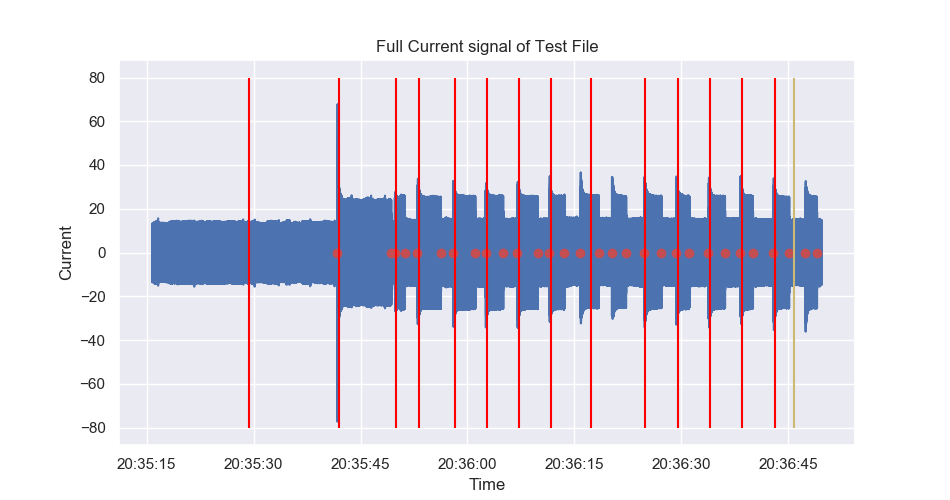

In [15]:
_, ax = plt.subplots(figsize=(9.5,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=found_events, color='red',ymin=-80, ymax=80, zorder=101)

#end of sliding window
ax.vlines(x=data.index[window_stop], color='y',ymin=-80, ymax=80, zorder=101)
plt.show()